# Preprocessing and Modeling
Diagnosing Pneumonia with X-Ray image data.

## Table of Contents
* [Data Loading and EDA](#chapter1)
    
* [Modeling](#chapter2)
    

The first half of this notebook is the same as the Data Wrangling and EDA notebook. Because of the way the data is organized/transformed, it seemed more natural to proceed to the preprocessing/modeling in the same notebook (instead of loading into a separate one), so I'll make a link to where the Modeling begins. 

### Resources/References

In certain sections of this notebook, I found the following resources to be very helpful. I made note of where actual code from them was adapted for use, but wanted to include this at the beginning.  
https://docs.python.org/3/library/glob.html
https://www.kaggle.com/code/aakashnain/beating-everything-with-depthwise-convolution
https://marekpaulik.medium.com/imbalanced-dataset-image-classification-with-pytorch-6de864982eb1
https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html  
https://www.kaggle.com/code/fahadmehfoooz/pneumonia-classification-using-pytorch
https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial

## Data Loading and EDA <a class="anchor" id="chapter1"></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
#from PyTorch transfer learning tutorial nb
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
from pathlib import Path
from collections import Counter

In [4]:
data_dir = Path('../data/chest_xray')
train_dir = data_dir / 'train'
test_dir = data_dir / 'test'
val_dir = data_dir / 'val'

# Training Data

To begin, we need to load the images in our training set. Essentially, we will make a list of paths to each image, and then use a separate function later to read the image file.

In [5]:
normal_path = train_dir / 'NORMAL'
pneumo_path = train_dir / 'PNEUMONIA'

#lists of the images
normal = normal_path.glob('*jpeg')
pneumo = pneumo_path.glob('*jpeg')

# we will store the normal images with a 0, pneumo with a 1
train = []
for x in normal:
    train.append((x,0))
for y in pneumo:
    train.append((y,1))

In [6]:
#lets take a look at this
train[:3]

[(WindowsPath('../data/chest_xray/train/NORMAL/IM-0115-0001.jpeg'), 0),
 (WindowsPath('../data/chest_xray/train/NORMAL/IM-0117-0001.jpeg'), 0),
 (WindowsPath('../data/chest_xray/train/NORMAL/IM-0119-0001.jpeg'), 0)]

In [7]:
train[-3:]

[(WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_39.jpeg'),
  1),
 (WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_40.jpeg'),
  1),
 (WindowsPath('../data/chest_xray/train/PNEUMONIA/person9_bacteria_41.jpeg'),
  1)]

This looks like what we wanted, a single list with the paths to the normal images at the beginning, and pnemo images at the end. 

In [8]:
#create a pandas dataframe from this list
trainDF = pd.DataFrame(train, columns = ['image','label'],index = None)

In [9]:
trainDF.head()

,image,label
0,..\data\chest_xray\train\NORMAL\IM-0115-0001.jpeg,0
1,..\data\chest_xray\train\NORMAL\IM-0117-0001.jpeg,0
2,..\data\chest_xray\train\NORMAL\IM-0119-0001.jpeg,0
3,..\data\chest_xray\train\NORMAL\IM-0122-0001.jpeg,0
4,..\data\chest_xray\train\NORMAL\IM-0125-0001.jpeg,0


In [10]:
trainDF.tail()

,image,label
5211,..\data\chest_xray\train\PNEUMONIA\person99_vi...,1
5212,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5213,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5214,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1
5215,..\data\chest_xray\train\PNEUMONIA\person9_bac...,1


In [11]:
 trainDF.label.value_counts()

1    3875
0    1341
Name: label, dtype: int64

So, in our training data, we have 3875 images where the patient has pneumonia, and 1341 where the person is normal. 

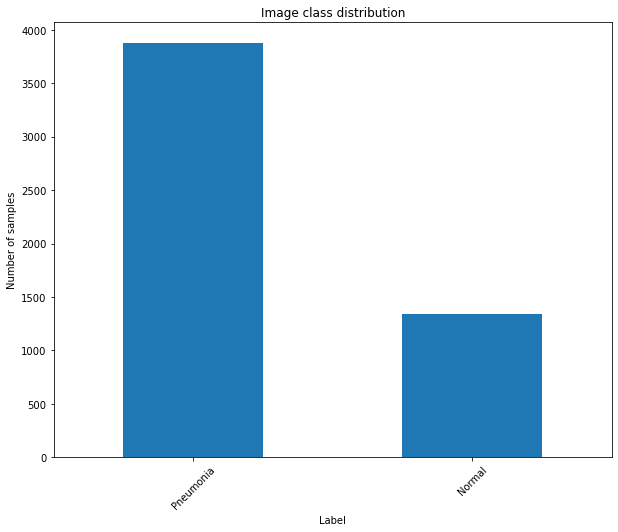

In [12]:
plt.figure(figsize = (10,8))
trainDF.label.value_counts().plot(kind = 'bar')
plt.xticks(ticks = [0,1],labels=['Pneumonia','Normal'],rotation = 45)
plt.xlabel('Label')
plt.ylabel('Number of samples')
plt.title('Image class distribution')
plt.show()

# Images in our training set



Here are 5 pictures of X-Ray's that were diagnosed with pneumonia

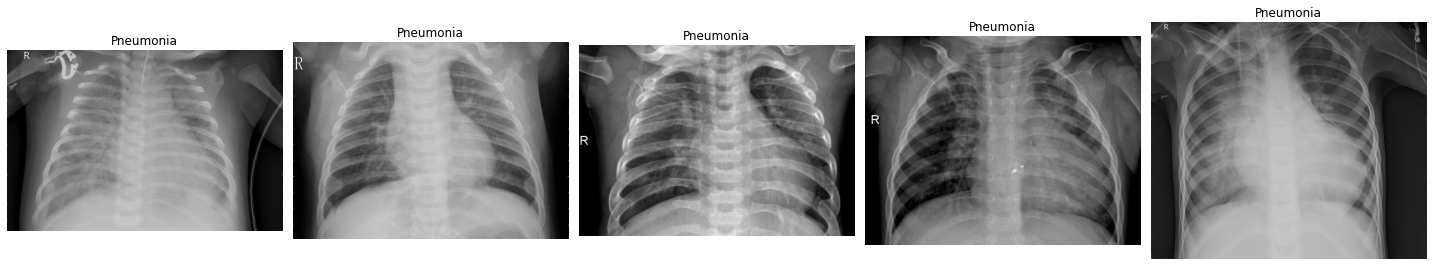

In [13]:
pneumo_pics = (trainDF[trainDF['label']==1]['image'].iloc[:5]).tolist()
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(pneumo_pics[i])
    #img = plt.imread(os.path(normal_path))
    plt.imshow(img, cmap='gray')
    plt.title("Pneumonia")
    plt.axis('off')
    
plt.tight_layout()

In [14]:
pneumo_pics

[WindowsPath('../data/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1001_bacteria_2932.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1002_bacteria_2933.jpeg'),
 WindowsPath('../data/chest_xray/train/PNEUMONIA/person1003_bacteria_2934.jpeg')]

And here are 5 pictures of X-Ray's that were diagnosed as normal.

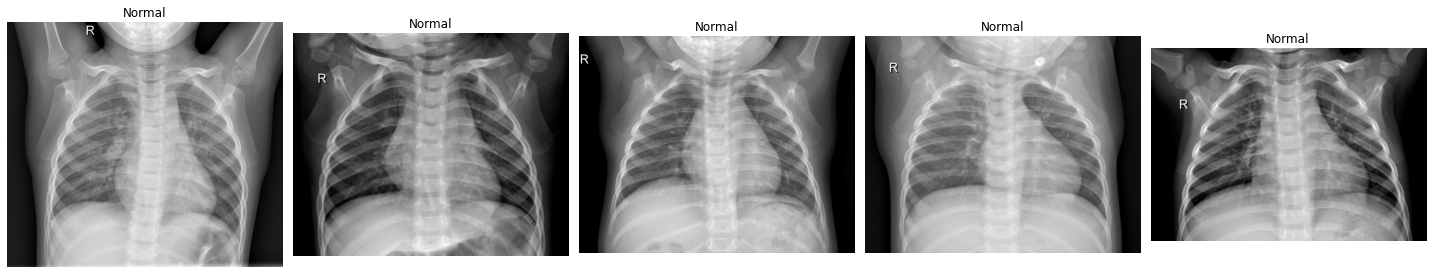

In [15]:
normal_pics = (trainDF[trainDF['label']==0]['image'].iloc[:5]).tolist()
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(normal_pics[i])
    #img = plt.imread(os.path(normal_path))
    plt.imshow(img, cmap='gray')
    plt.title("Normal")
    plt.axis('off')
    
plt.tight_layout()

Lets take a look at a bigger version of a normal image, this time with the grayscale colorbar added

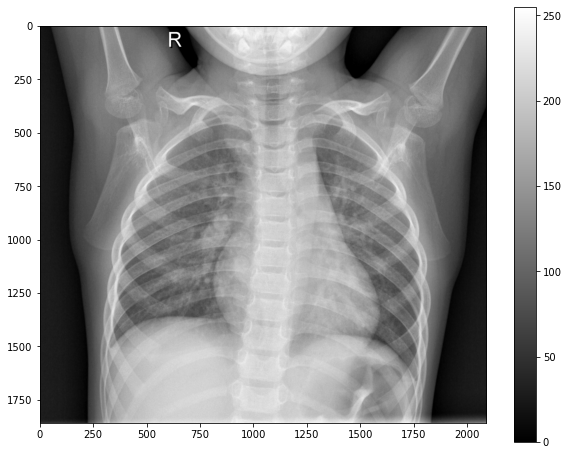

In [16]:
plt.figure(figsize = (10,8))
img = plt.imread(normal_pics[0])
plt.imshow(img,cmap='gray')
plt.colorbar()
plt.show()

In [17]:
img.shape

(1858, 2090)

In [18]:
#Lets see what some of the other image dimensions are. 

for i in range(5):
    img = plt.imread(normal_pics[i])
    print(img.shape)

(1858, 2090)
(1152, 1422)
(1434, 1810)
(1279, 1618)
(1125, 1600)


In [19]:
for i in range(5):
    img = plt.imread(pneumo_pics[i])
    print(img.shape)

(760, 1152)
(768, 1072)
(863, 1244)
(940, 1242)
(1280, 1488)


We will want to include resizing in our preprocessing to account for the differences in image size seen here. 

# Image Augmentations

We will use the torchvision transforms library in this section. There are 2 main objectives here. The first is to balance our classes, that is to use augmentations to increase the number of "normal" class images in our training data to match the number of "pneumonia" class images. The second is to resize the images and normalize their channel values to have consistent data to train our network on. For now we will use the mean and std from imagenet for normalization ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), but may play with this in the tuning stage of the project. 

## Class Imbalance

There are several ways we could go about dealing with the class imbalance. We could generate more "Normal" images, and add them in to our current normal images before training. 
Alternatively, we could write a function to generate images as we go on a batch by batch basis, or change the weighting in the loss function used.

For now we will try generating more "normal" images using augmentations. In our training set, there are 3875 "Pneumonia" images and 1341 "Normal" images. his means we need more than twice the number of images currently availible. So, we will use 2 sets of transform compositions to augment the original training data. For the sake of avoiding duplicates/unrepresentative data, I didn't want to perform the same transforms twice in a row. Because we are dealing with medical images, some augmentation techniques wouldn't make much sense (i.e. horizontal reflections), as such an image would never be possible from scanning a human body. I also didn't want to blur, crop or rotate the images too dramatically, as any future data probably wouldn't be well represented by this. 


### Note

After running several models with different training data transforms, adding back in extra normal images a priori doesn't appear to help. The best performance actually came from using a small validation set (in training), and the imbalanced classes. 

In [20]:
class_names = ['NORMAL', 'PNEUMONIA']

In [21]:
def imshow(inp, figsize = (20,20),title=None):
    """Imshow for Tensor.
    This function is modified from the PyTorch transfer learning tutorial notebook
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


### First set of transforms

### Final set of transforms for all training data

In [22]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [23]:
train_data = datasets.ImageFolder(train_dir, transform = data_transforms['train'])
test_data = datasets.ImageFolder(test_dir, transform = data_transforms['test'])
val_data = datasets.ImageFolder(val_dir,transform = data_transforms['val'])

In [24]:
train_data.classes

['NORMAL', 'PNEUMONIA']

In [25]:
class_names = train_data.classes

## Preprocessing & Modeling <a class="anchor" id="chapter2"></a>

We will employ transfer learning with a CNN trained on imagenet data (namely Resnet50). 

At first I divided the data to have an extra validation set with the augmented the training data (now 7748 images).
Eventually I ended up using the original imbalanced data with a much smaller validation set.  
The final test set for model evaluation/selection was kept separate from everything else until the end. 

### Creating dataloaders for our datasets

In [26]:
dataset_sizes = {'train': len(train_data), 'val':len(val_data),'test': len(test_data)}

In [27]:
dataset_sizes

{'train': 5216, 'val': 16, 'test': 624}

In [28]:
trainDL = DataLoader(train_data, batch_size = 16, shuffle = True, num_workers = 6,pin_memory=True)

In [29]:
valDL = DataLoader(val_data, batch_size = 16, shuffle = True, num_workers = 6, pin_memory = True)

In [30]:
testDL = DataLoader(test_data, batch_size = 16, shuffle = True, num_workers = 6, pin_memory = True)

In [31]:
dataloaders = {'train': trainDL, 'val':valDL, 'test':testDL}

Lets take a look at what a single batch from our training data looks like

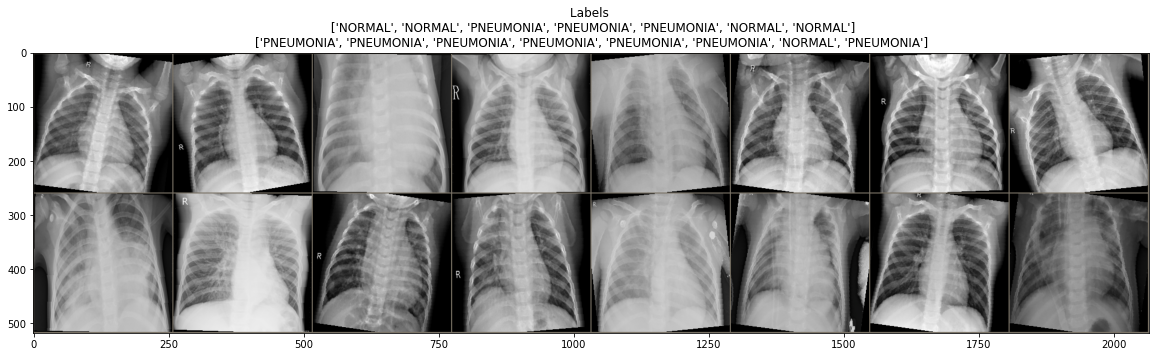

In [32]:
# Get a batch of training data
inputs, classes = next(iter(trainDL))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#Split the title

batchnames = [class_names[x] for x in classes]

imshow(out, title = "Labels \n "+ str(batchnames[:7])+"\n"+str(batchnames[8:]))

# Model Training 

The following 2 functions are modified from the pytorch transfer learning tutorial documentation which can be found at the following link. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html



In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [34]:
#could make an alteration to not necesarily set model to best weights based on val score here
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [63]:
#could make an alteration to not necesarily set model to best weights based on val score here
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'train' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [64]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize = (8,8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.plot(figsize = (8,8))
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                plt.xlabel(labels[j])
                imshow(inputs.cpu().data[j],figsize = (4,4))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Transfer Learning with Resnet18

In [65]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [66]:
#load in the pretrained model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Here is where we begin training

In [67]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 0.1323 Acc: 0.9519
val Loss: 0.1085 Acc: 1.0000

Epoch 1/14
----------
train Loss: 0.0630 Acc: 0.9793
val Loss: 0.5886 Acc: 0.6875

Epoch 2/14
----------
train Loss: 0.0501 Acc: 0.9824
val Loss: 0.0712 Acc: 1.0000

Epoch 3/14
----------
train Loss: 0.0328 Acc: 0.9875
val Loss: 0.0667 Acc: 1.0000

Epoch 4/14
----------
train Loss: 0.0276 Acc: 0.9910
val Loss: 0.2859 Acc: 0.8750

Epoch 5/14
----------
train Loss: 0.0227 Acc: 0.9935
val Loss: 0.1477 Acc: 0.9375

Epoch 6/14
----------
train Loss: 0.0152 Acc: 0.9941
val Loss: 0.2151 Acc: 0.9375

Epoch 7/14
----------
train Loss: 0.0107 Acc: 0.9977
val Loss: 0.1676 Acc: 0.9375

Epoch 8/14
----------
train Loss: 0.0073 Acc: 0.9990
val Loss: 0.2139 Acc: 0.9375

Epoch 9/14
----------
train Loss: 0.0075 Acc: 0.9985
val Loss: 0.2047 Acc: 0.9375

Epoch 10/14
----------
train Loss: 0.0076 Acc: 0.9981
val Loss: 0.1558 Acc: 0.9375

Epoch 11/14
----------
train Loss: 0.0089 Acc: 0.9985
val Loss: 0.2227 Acc: 0.9375

Ep

In [39]:
#visualize_model(model_ft)

In [68]:
test_load = DataLoader(test_data, batch_size = 1)

Comprehensive metrics function. After running it for the first time, it's quicker to just call the individual metrics if you want to go back and check certain things, so both will be left in.

Several of these following evaluation techniques were adapted from "arunrk7"'s tutorial on Kaggle which can be found here
    https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial

In [69]:
def ez_metrics(model, test_data = test_data):
    from sklearn.metrics import classification_report, f1_score
    from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

    test_load = DataLoader(test_data, batch_size = 1)
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        for imgs, labels in test_load:
            x_batch, y_batch = imgs.to(device), labels.to(device)
            y_test_pred = model_ft(x_batch)
            y_test_pred = torch.log_softmax(y_test_pred, dim=1)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(y_batch.cpu().numpy())
    y_pred_list = [i[0] for i in y_pred_list]
    y_true_list = [i[0] for i in y_true_list]
    print(classification_report(y_true_list, y_pred_list))
    print("Accuracy Score:  ", accuracy_score(y_true_list, y_pred_list))
    print("F1 Score:  ", f1_score(y_true_list, y_pred_list))
    fig, ax = plt.subplots(figsize=(8,6))
    cm = confusion_matrix(y_true_list, y_pred_list)
    disp = ConfusionMatrixDisplay(cm, display_labels = [0,1])
    disp.plot(ax=ax)  
    return y_pred_list, y_true_list

              precision    recall  f1-score   support

           0       0.99      0.62      0.76       234
           1       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.81      0.83       624
weighted avg       0.88      0.86      0.85       624

Accuracy Score:   0.8557692307692307
F1 Score:   0.8960739030023095


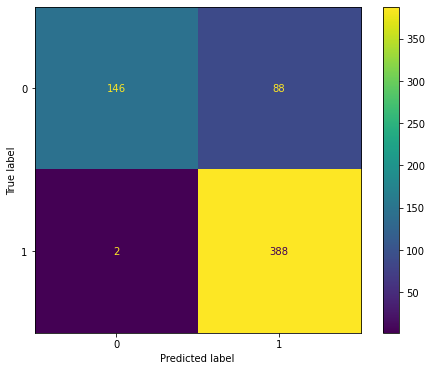

In [70]:
y_p, x_p = ez_metrics(model_ft, test_data)

In [71]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for imgs, labels in test_load:
        x_batch, y_batch = imgs.to(device), labels.to(device)
        y_test_pred = model_ft(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [72]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [73]:
len(y_pred_list)

624

In [74]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import  f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [75]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.99      0.62      0.76       234
           1       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.81      0.83       624
weighted avg       0.88      0.86      0.85       624



In [76]:
accuracy_score(y_true_list, y_pred_list)

0.8557692307692307

In [77]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

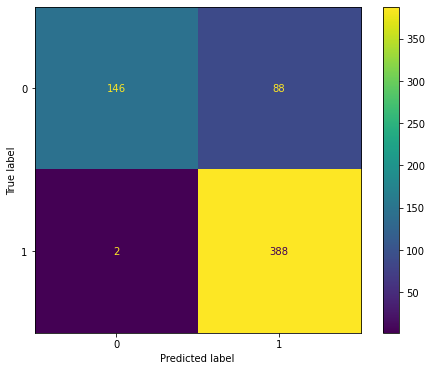

In [78]:
fig, ax = plt.subplots(figsize=(8,6))
cm = confusion_matrix(y_true_list, y_pred_list)
disp = ConfusionMatrixDisplay(cm, display_labels = [0,1])
disp.plot(ax=ax)      

Note: False positives are better than false negatives in this scenario. 

In [79]:
f1_score(y_true_list, y_pred_list)

0.8960739030023095

In [54]:
#torch.save(model_ft.state_dict(), '../models/model92A-ft')

In [69]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Feature extraction

Freezing the network except for the final layer. 

In [52]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [53]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 0.2487 Acc: 0.8934
val Loss: 0.4355 Acc: 0.7500

Epoch 1/14
----------
train Loss: 0.1667 Acc: 0.9365
val Loss: 0.2772 Acc: 0.9375

Epoch 2/14
----------
train Loss: 0.1651 Acc: 0.9369
val Loss: 0.4669 Acc: 0.8125

Epoch 3/14
----------
train Loss: 0.1452 Acc: 0.9415
val Loss: 0.1817 Acc: 0.9375

Epoch 4/14
----------
train Loss: 0.1486 Acc: 0.9411
val Loss: 0.4416 Acc: 0.7500

Epoch 5/14
----------
train Loss: 0.1410 Acc: 0.9456
val Loss: 0.4772 Acc: 0.7500

Epoch 6/14
----------
train Loss: 0.1414 Acc: 0.9467
val Loss: 0.2415 Acc: 0.9375

Epoch 7/14
----------
train Loss: 0.1192 Acc: 0.9569
val Loss: 0.3683 Acc: 0.8125

Epoch 8/14
----------
train Loss: 0.1195 Acc: 0.9536
val Loss: 0.3635 Acc: 0.8125

Epoch 9/14
----------
train Loss: 0.1304 Acc: 0.9459
val Loss: 0.4078 Acc: 0.8125

Epoch 10/14
----------
train Loss: 0.1245 Acc: 0.9532
val Loss: 0.4282 Acc: 0.7500

Epoch 11/14
----------
train Loss: 0.1257 Acc: 0.9525
val Loss: 0.4736 Acc: 0.7500

Ep

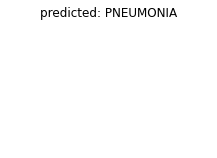

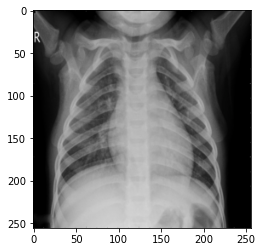

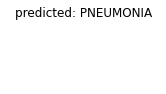

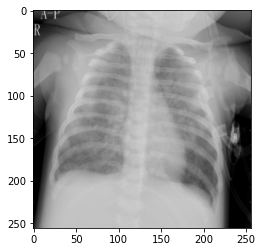

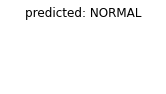

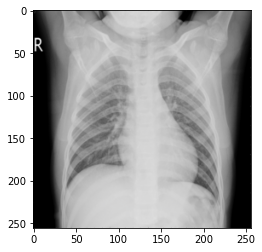

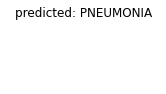

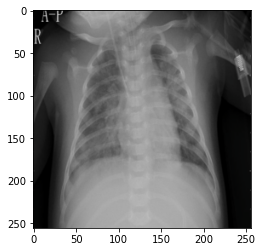

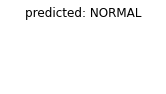

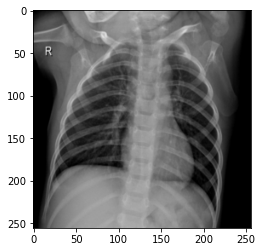

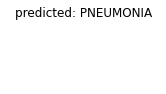

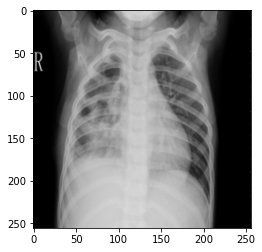

In [54]:
visualize_model(model_conv)


In [55]:
test_load = DataLoader(test_data, batch_size = 1)

In [56]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for imgs, labels in test_load:
        x_batch, y_batch = imgs.to(device), labels.to(device)
        y_test_pred = model_conv(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [57]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [58]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86       234
           1       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



In [59]:
f1_score(y_true_list, y_pred_list)

0.9236453201970444

In [60]:
accuracy_score(y_true_list, y_pred_list)

0.9006410256410257

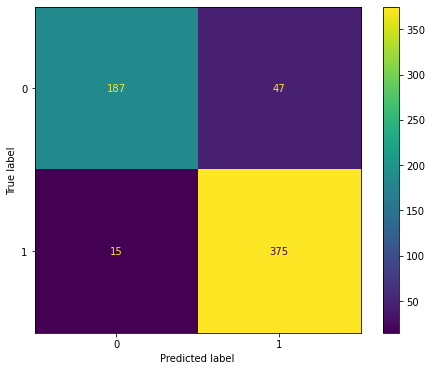

In [61]:
fig, ax = plt.subplots(figsize=(8,6))
cm = confusion_matrix(y_true_list, y_pred_list)
disp = ConfusionMatrixDisplay(cm, display_labels = [0,1])
disp.plot(ax=ax)      

              precision    recall  f1-score   support

           0       0.98      0.77      0.86       234
           1       0.88      0.99      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.92      0.91      0.90       624

Accuracy Score:   0.907051282051282
F1 Score:   0.9301204819277108


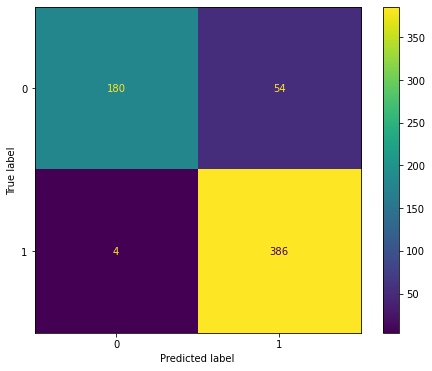

In [62]:
xx,yy = ez_metrics(model_conv, test_data)

In [65]:
torch.save(model_ft.state_dict(), '../models/model15-90A-Fr')

In [70]:
model_conv

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Summary

The best performing model yielded an accuracy of over 0.92 and f1-score over 0.94, which is much better than the first attempts (~ 70-75% accuracy).
